# Testing SR-IS vs SR on 4-room replanning

In [25]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym

import gym_env
from utils import test_agent, get_full_maze_values, create_mapping_nb
from models import SR_IS, SR_TD

In [26]:
# Set the seed
seed = 26
np.random.seed(seed)
seeds = np.arange(40)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [27]:
# Model Hyperparams
reward = -0.1
term_reward = 10
alpha = 0.2
beta = 1.0
_lambda = 1.0
num_steps = 30000
num_simulations = 20

# Original term state
# learn_term_state = (6,6)
learn_term_state = (0,6)

# New term states
# term_states = {
#     "same" : [(4,6), (6,4)],
#     "different" : [(0,4), (0,6), (2,6), (4,0), (6,0), (6,2)],
# }
term_states = {
    "same" : [(0,4), (2,6)],
    "different" : [(4,6), (6,4), (6,6), (4,0), (6,0), (6,2)],
}

In [28]:
env = gym.make("four-room-sg")
maze = env.unwrapped.maze
mapping = create_mapping_nb(env.unwrapped.maze, env.unwrapped.get_walls())

In [29]:
avgs_random = {
    'same':{'mean':[],'median':[]},
    'different':{'mean':[],'median':[]}
}
avgs_sr = {
    'same':{'mean':[],'median':[]},
    'different':{'mean':[],'median':[]}
}
avgs_sr_is = {
    'same':{'mean':[],'median':[]},
    'different':{'mean':[],'median':[]}
}

In [30]:
# Loop through the seeds
for seed in seeds:
    print(f"Seed: {seed}")
    ##  Learning Phase  ##
    # Initialize agents
    SR_IS_agent = SR_IS(env_name="four-room-sg", reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True)
    Random_agent = SR_IS(env_name="four-room-sg", reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, num_steps=num_steps, policy="random", imp_samp=False)
    SR_agent = SR_TD(env_name="four-room-tr", gamma=0.95, reward=0,  term_reward=10, beta=beta, alpha=0.2, num_steps=num_steps, policy="softmax")

    # Base reward vectors
    r_base_is = np.copy(SR_IS_agent.r)
    r_base_sr = np.copy(SR_agent.r)

    # Learning reward vectors
    # SR-IS
    r_learn_is = np.copy(SR_IS_agent.r)
    r_learn_is[mapping[learn_term_state]] = term_reward
    SR_IS_agent.expr_t = np.exp(r_learn_is[SR_IS_agent.terminals] / _lambda)
    SR_IS_agent.r = r_learn_is

    # SR
    r_learn_sr = np.copy(SR_agent.r)
    r_learn_sr[mapping[learn_term_state]] = term_reward
    SR_agent.r = r_learn_sr

    # Lear
    SR_IS_agent.learn(seed=int(seed))
    SR_agent.learn(seed=int(seed))


    ##  Reval Phase  ##
    # Loop through the different terminal states
    for room, terminal_locs in term_states.items():
        # Loop through the different terminal locations
        for term_loc in terminal_locs:
            term_idx = mapping[term_loc]
            # Construct new reward vectors for SR-IS and SR agents
            r_new_is = np.copy(r_base_is)
            r_new_is[term_idx] = term_reward
            r_new_sr = np.copy(r_base_sr)
            r_new_sr[term_idx] = term_reward

            # Use new reward vector to update representations
            SR_IS_agent.r = r_new_is
            SR_agent.r = r_new_sr

            # Update SR-IS
            SR_IS_agent.expr_t = np.exp(r_new_is[SR_IS_agent.terminals] / _lambda)
            SR_IS_agent.update_V()

            # Update SR
            SR_agent.update_V()

            # Test the agents
            # Initialize holders and run simulations
            SR_IS_avg, Random_avg, SR_td_avg = [],[],[]
            for i in range(num_simulations):
                SR_IS_avg.append(len(test_agent(agent=SR_IS_agent, policy=SR_IS_agent.policy, seed=int(seed), term_state=term_loc)))
                Random_avg.append(len(test_agent(agent=Random_agent, policy=Random_agent.policy, seed=int(seed), term_state=term_loc)))
                SR_td_avg.append(len(test_agent(agent=SR_agent, policy=SR_agent.policy, seed=int(seed), term_state=term_loc)))
            
            # Append mean and median to main holder
            avgs_sr_is[room]['mean'].append(np.mean(SR_IS_avg))
            avgs_sr_is[room]['median'].append(np.median(SR_IS_avg))
            avgs_random[room]['mean'].append(np.mean(Random_avg))
            avgs_random[room]['median'].append(np.median(Random_avg))
            avgs_sr[room]['mean'].append(np.mean(SR_td_avg))
            avgs_sr[room]['median'].append(np.median(SR_td_avg))

Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Seed: 10
Seed: 11
Seed: 12
Seed: 13
Seed: 14
Seed: 15
Seed: 16
Seed: 17
Seed: 18
Seed: 19
Seed: 20
Seed: 21
Seed: 22
Seed: 23
Seed: 24
Seed: 25
Seed: 26
Seed: 27
Seed: 28
Seed: 29
Seed: 30
Seed: 31
Seed: 32
Seed: 33
Seed: 34
Seed: 35
Seed: 36
Seed: 37
Seed: 38
Seed: 39


In [31]:
stat_type = 'mean'
rooms = ['same', 'different']
avgs = [avgs_random, avgs_sr, avgs_sr_is]

means = [np.mean(avg[room][stat_type]) for room in rooms for avg in avgs]
sems = [np.std(avg[room][stat_type]) / np.sqrt(len(avg[room][stat_type])) for room in rooms for avg in avgs]
print(means)
print(sems)

[163.15, 34.5, 15.525, 219.925, 207.45833333333334, 23.891666666666666]
[15.842536689242667, 2.6199952290032895, 0.9573686267577396, 12.909768756266617, 16.424878225139086, 1.0754939379876336]


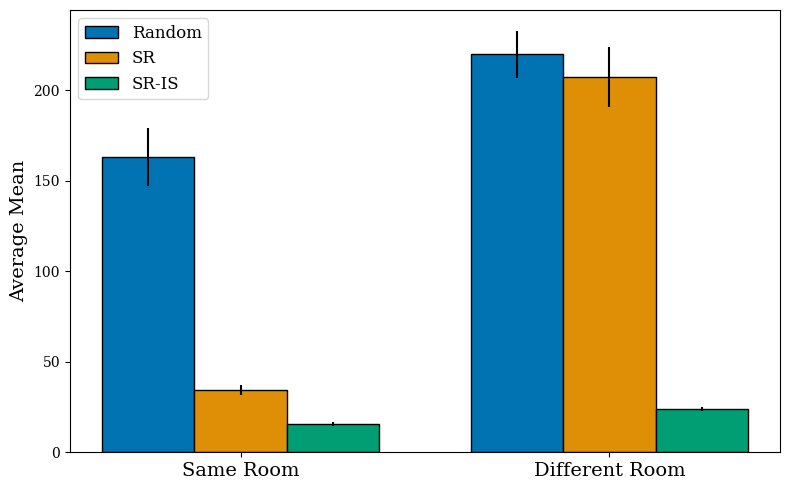

In [33]:
# Set style parameters
plt.rcParams['font.family'] = 'serif'

save_path = None
stat_type = 'mean'

# Prepare data
rooms = ['same', 'different']
avgs = [avgs_random, avgs_sr, avgs_sr_is]

means = [np.mean(avg[room][stat_type]) for room in rooms for avg in avgs]
sems = [np.std(avg[room][stat_type]) / np.sqrt(len(avg[room][stat_type])) for room in rooms for avg in avgs]

# Create figure
plt.figure(figsize=(8, 5))

# Set bar positions
bar_width = 0.25
r1 = np.arange(2)  # positions for 'same' and 'different'
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create color palette
palette = sns.color_palette("colorblind", 3)

# Create bars with black edges
plt.bar(r1, [means[0], means[3]], width=bar_width, label='Random', 
        color=palette[0], yerr=[sems[0], sems[3]], capsize=0, 
        edgecolor='black', linewidth=1)
plt.bar(r2, [means[1], means[4]], width=bar_width, label='SR', 
        color=palette[1], yerr=[sems[1], sems[4]], capsize=0, 
        edgecolor='black', linewidth=1)
plt.bar(r3, [means[2], means[5]], width=bar_width, label='SR-IS', 
        color=palette[2], yerr=[sems[2], sems[5]], capsize=0, 
        edgecolor='black', linewidth=1)

# Add labels and title
plt.ylabel(f'Average {stat_type.capitalize()}', fontsize=14)

# Add xticks
plt.xticks([r + bar_width for r in range(2)], ['Same Room', 'Different Room'], fontsize=14)

# Add legend
plt.legend(fontsize=12)

# Adjust layout
plt.tight_layout()

# Save if path provided
if save_path:
    plt.savefig(save_path, bbox_inches='tight', dpi=300)

# Show plot
plt.show()

In [6]:
SR_IS_agent = SR_IS(env_name="four-room-sg", reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True)
Random_agent = SR_IS(env_name="four-room-sg", reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, num_steps=num_steps, policy="random", imp_samp=False)
SR_agent = SR_TD(env_name="four-room-br", gamma=0.95, reward=0,  term_reward=0, beta=beta, alpha=0.2, num_steps=num_steps, policy="softmax")

In [7]:
r_base_is = np.copy(SR_IS_agent.r)
r_base_sr = np.copy(SR_agent.r)

In [8]:
# SR-IS
r_learn_is = np.copy(SR_IS_agent.r)
r_learn_is[mapping[learn_term_state]] = term_reward
SR_IS_agent.expr_t = np.exp(r_learn_is[SR_IS_agent.terminals] / _lambda)
SR_IS_agent.r = r_learn_is

# SR
r_learn_sr = np.copy(SR_agent.r)
r_learn_sr[mapping[learn_term_state]] = term_reward
SR_agent.r = r_learn_sr

In [9]:
SR_agent.r

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 10])

In [10]:
# Train agents that need to be trained
SR_IS_agent.learn(seed=int(seed))
SR_agent.learn(seed=int(seed))

In [11]:
# D_inv = SR_IS_agent.get_D_inv()
# SR_IS_agent.DR = D_inv
# SR_IS_agent.update_V()

In [12]:
get_full_maze_values(SR_IS_agent)

array([[ 2.94,  3.04,  3.22,  -inf, -0.1 ,  4.9 , -0.1 ],
       [ 3.04,  3.22,  3.55,  4.27,  4.81,  5.  ,  4.9 ],
       [ 3.22,  3.54,  3.45,  -inf,  5.16,  5.51, -0.1 ],
       [ -inf,  4.26,  -inf,  -inf,  -inf,  6.33,  -inf],
       [-0.1 ,  4.8 ,  5.13,  -inf,  6.82,  6.96, -0.1 ],
       [ 4.9 ,  4.99,  5.49,  6.36,  6.96,  8.03,  8.68],
       [-0.1 ,  4.9 , -0.1 ,  -inf, -0.1 ,  9.62, 10.  ]])

In [13]:
get_full_maze_values(SR_agent)

array([[ 0.83,  0.88,  1.  ,  -inf,  1.98,  1.91,  1.87],
       [ 0.83,  0.95,  1.24,  1.68,  1.99,  2.17,  1.89],
       [ 0.83,  0.94,  0.99,  -inf,  2.27,  2.56,  2.11],
       [ -inf,  1.19,  -inf,  -inf,  -inf,  4.26,  -inf],
       [ 1.47,  1.57,  1.95,  -inf,  5.31,  5.33,  7.29],
       [ 1.51,  1.66,  2.57,  4.78,  6.26,  5.96,  8.33],
       [ 1.51,  1.61,  2.15,  -inf,  7.61,  8.28, 10.  ]])

In [14]:
# # Get new terminal index and location
new_term_idx = mapping[term_states["same"][0]]
new_term_loc = term_states["same"][0]

In [15]:
# Construct new reward vectors for SR-IS and SR agents
r_new_is = np.copy(r_base_is)
r_new_is[new_term_idx] = term_reward
r_new_sr = np.copy(r_base_sr)
r_new_sr[new_term_idx] = term_reward

In [16]:
# Use new reward vector to update representations
SR_IS_agent.r = r_new_is
SR_agent.r = r_new_sr

# Update SR-IS
SR_IS_agent.expr_t = np.exp(r_new_is[SR_IS_agent.terminals] / _lambda)
SR_IS_agent.update_V()

# Update SR
SR_agent.update_V()

In [17]:
get_full_maze_values(SR_IS_agent)

array([[ 3.58,  3.7 ,  3.99,  -inf, -0.1 ,  5.34, -0.1 ],
       [ 3.61,  3.76,  4.38,  5.23,  5.63,  6.22,  5.33],
       [ 3.74,  4.01,  3.98,  -inf,  6.66,  7.43, -0.1 ],
       [ -inf,  4.69,  -inf,  -inf,  -inf,  8.66,  -inf],
       [-0.1 ,  5.14,  5.83,  -inf,  8.7 ,  9.18, 10.  ],
       [ 4.82,  5.43,  6.2 ,  7.28,  7.84,  9.35,  8.82],
       [-0.1 ,  4.97, -0.1 ,  -inf, -0.1 ,  6.87, -0.1 ]])

In [18]:
get_full_maze_values(SR_agent)

array([[ 1.  ,  1.11,  1.35,  -inf,  3.22,  3.1 ,  3.02],
       [ 0.96,  1.21,  1.77,  2.65,  3.26,  3.6 ,  3.07],
       [ 0.91,  0.94,  1.23,  -inf,  3.78,  4.37,  3.5 ],
       [ -inf,  0.96,  -inf,  -inf,  -inf,  7.11,  -inf],
       [ 0.99,  1.04,  1.23,  -inf,  4.85,  8.85, 17.06],
       [ 1.  ,  1.07,  1.51,  2.29,  2.07,  4.24,  6.27],
       [ 0.99,  1.05,  1.33,  -inf,  1.43,  1.36,  0.32]])

In [19]:
# Initialize holders and run simulations
SR_IS_avg, Random_avg, SR_td_avg = [],[],[]
for i in range(num_simulations):
    SR_IS_avg.append(len(test_agent(agent=SR_IS_agent, policy=SR_IS_agent.policy, seed=int(seed), term_state=new_term_loc)))
    Random_avg.append(len(test_agent(agent=Random_agent, policy=Random_agent.policy, seed=int(seed), term_state=new_term_loc)))
    SR_td_avg.append(len(test_agent(agent=SR_agent, policy=SR_agent.policy, seed=int(seed), term_state=new_term_loc)))

[0 0] 0
[1 0] 1
[1 1] 2
[0 1] 3
[0 0] 1
[0 1] 0
[1 1] 1
[1 2] 1
[1 3] 3
[1 2] 1
[1 3] 1
[1 4] 1
[1 5] 0
[2 5] 2
[1 5] 0
[2 5] 0
[3 5] 2
[2 5] 3
[2 4] 1
[2 5] 1
[2 6] 3
[2 5] 1
[2 6] 3
[2 5] 0
[3 5] 2
[2 5] 2
[1 5] 2
[0 5] 0
[1 5] 2
[0 5] 3
[0 4] 1
[0 5] 3
[0 4] 1
[0 5] 1
[0 6] 0
[1 6] 3
[1 5] 0
[2 5] 0
[3 5] 0
[4 5] 1
[0 0] 0
[1 0] 1
[1 1] 2
[0 1] 3
[0 0] 1
[0 1] 0
[1 1] 1
[1 2] 1
[1 3] 3
[1 2] 1
[1 3] 1
[1 4] 1
[1 5] 0
[2 5] 2
[1 5] 0
[2 5] 0
[3 5] 2
[2 5] 3
[2 4] 1
[2 5] 1
[2 6] 3
[2 5] 1
[2 6] 3
[2 5] 0
[3 5] 2
[2 5] 2
[1 5] 2
[0 5] 0
[1 5] 2
[0 5] 3
[0 4] 1
[0 5] 3
[0 4] 1
[0 5] 1
[0 6] 0
[1 6] 3
[1 5] 0
[2 5] 0
[3 5] 0
[4 5] 1


In [18]:
# Append mean and median to main holder
avgs['SR-IS']['mean'].append(np.mean(SR_IS_avg))
avgs['SR-IS']['median'].append(np.median(SR_IS_avg))
avgs['Random']['mean'].append(np.mean(Random_avg))
avgs['Random']['median'].append(np.median(Random_avg))
avgs['SR']['mean'].append(np.mean(SR_td_avg))
avgs['SR']['median'].append(np.median(SR_td_avg))

In [19]:
avgs

{'Random': {'mean': [232.0], 'median': [232.0]},
 'SR': {'mean': [106.0], 'median': [106.0]},
 'SR-IS': {'mean': [10.0], 'median': [10.0]}}